In [1]:
import torch
import skripsi_program
from skripsi_program import SpectralSVR, to_complex_coeff, to_real_coeff, FourierBasis, LSSVR, StandardScaler, reduce_coeff, rmse, mse
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
generator = torch.Generator().manual_seed(42)
modes = [200]
prod_modes = int(np.prod(modes))
num_samples = 201
k = FourierBasis.waveNumber(prod_modes)
u_coeff_clean = FourierBasis.generateCoeff(num_samples, prod_modes, generator=generator, random_func=torch.rand)
ut_coeff_clean = u_coeff_clean * 2j * torch.pi * k.T / prod_modes
utt_coeff_clean = ut_coeff_clean * 2j * torch.pi * k.T / prod_modes # d2f/dt2
# u_coeff = u_coeff.reshape((-1, *modes))
# f_coeff = f_coeff.reshape((-1, *modes))
u_coeff_clean.shape

torch.Size([201, 200])

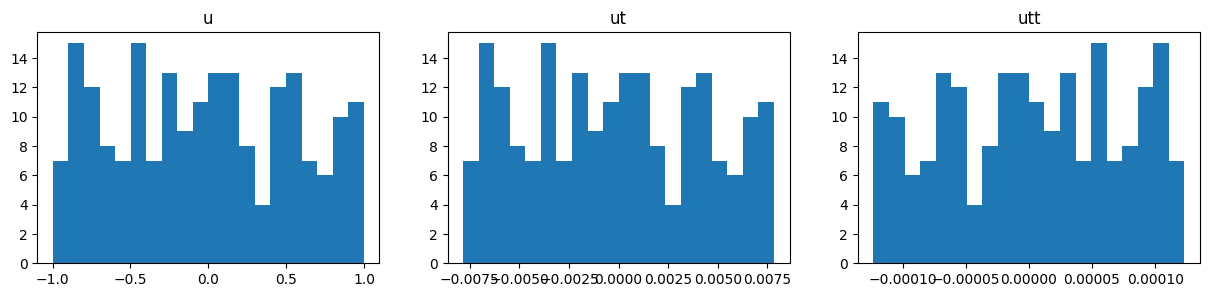

In [4]:
def visualize_dist_coeff(dim=0):
    fig, axs = plt.subplots(1, 3, figsize=[15,3])

    axs[0].hist(u_coeff_clean[:,dim].real, bins = 20)
    axs[0].set_title("u")
    axs[1].hist(ut_coeff_clean[:,dim].imag/8, bins = 20)
    axs[1].set_title("ut")
    axs[2].hist(utt_coeff_clean[:,dim].real/32, bins = 20)
    axs[2].set_title("utt")
    plt.show()
visualize_dist_coeff(2)

torch.Size([201, 900])

tensor(30.0149)

tensor(-59.1061)

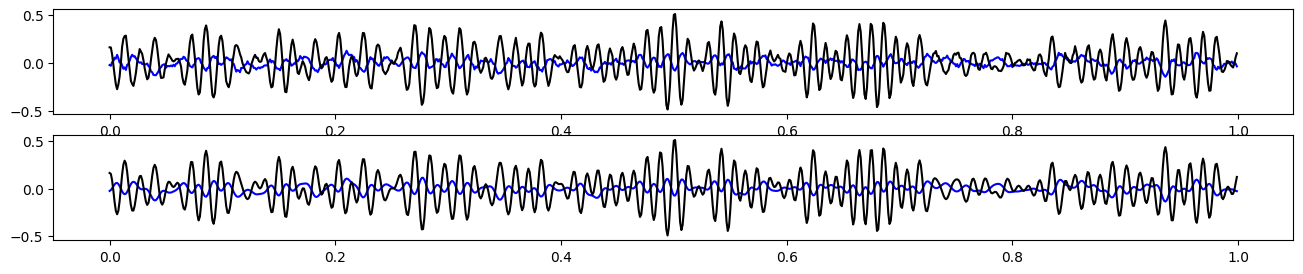

In [5]:
sample_freq = 900.0
sample_step = 1.0 / sample_freq
periods = [1.0] * len(modes)
t = torch.arange(0, 1, sample_step)
tmp = [t for i in range(len(modes))]
tt = torch.meshgrid(tmp, indexing="ij")
points_tt = torch.concat([t.flatten().unsqueeze(-1) for t in tt], 1)
u_basis = FourierBasis(u_coeff_clean, periods)
ut_basis = FourierBasis(ut_coeff_clean, periods)
utt_basis = FourierBasis(utt_coeff_clean, periods)
u_clean = u_basis.evaluate(points_tt).real
ut_clean = ut_basis.evaluate(points_tt).real
utt_clean = utt_basis.evaluate(points_tt).real
u = u_clean + torch.randn_like(u_clean) * 0.01
ut = ut_clean + torch.randn_like(ut_clean) * 0.01
utt = utt_clean + torch.randn_like(utt_clean) * 0.01
u_coeff = reduce_coeff(FourierBasis.transform(u), modes)
ut_coeff = reduce_coeff(FourierBasis.transform(ut), modes)
utt_coeff = reduce_coeff(FourierBasis.transform(utt), modes)
u_shape = u.shape


def signal_stats():
    # u_real, u_clean_real = to_real_coeff(u), to_real_coeff(u_clean)
    u_real, u_clean_real = to_real_coeff(u_coeff), to_real_coeff(u_coeff_clean)
    l2_error = rmse(u_real, u_clean_real)
    MSE = mse(u_real, u_clean_real)
    display(u_shape)
    display(l2_error)
    display(20 * u_clean_real.max().log10() - 10 * MSE.pow(2).log10())


signal_stats()

plt.figure(figsize=(16, 3))
plt.subplot(211)
plt.plot(t, u[2].real, color="b")
plt.plot(t, utt[2].real, color="k")
plt.subplot(212)
plt.plot(t, u_clean[2].real, color="b")
plt.plot(t, utt_clean[2].real, color="k")
plt.show()

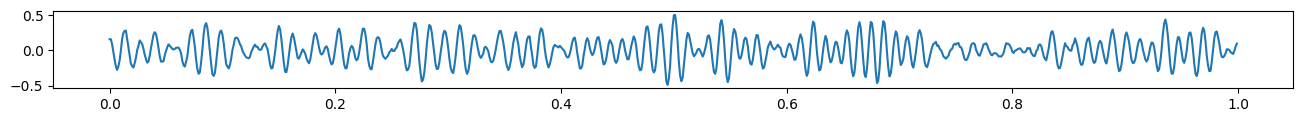

In [6]:
from torch.utils.data import TensorDataset, random_split
data = (utt, utt_coeff, u, u_coeff)
(utt_scaled, utt_coeff_scaled, u_scaled, u_coeff_scaled) = data
# scaler = StandardScaler()
# (utt_scaled, utt_coeff_scaled, u_scaled, u_coeff_scaled) = scaler.fit(data).transform(
#     data
# )
dataset = TensorDataset(utt_scaled, utt_coeff_scaled, u_scaled, u_coeff_scaled)
dataset_train, dataset_test = random_split(
    dataset, (0.8, 0.2), generator=torch.Generator().manual_seed(42)
)
# f_train, f_coeff_train, u_train, u_coeff_train = dataset_train[:]
# f_test, f_coeff_test, u_test, u_coeff_test = dataset_test[:]
# f_train.shape, f_coeff_train.shape, u_coeff_train.shape
plt.figure(figsize=(16,1))
plt.plot(points_tt[:], dataset[2][0])
plt.show()

In [7]:
f_train, f_coeff_train, u_train, u_coeff_train = dataset_train[:]
f_input_train = f_train
# f_input_train = to_real_coeff(f_coeff_train)

# model = SpectralSVR(FourierBasis(periods=periods), C=41.6207,sigma=4.0776, kernel="linear")
model = SpectralSVR(
    FourierBasis(periods=periods),
    C=1.0,
    sigma=(f_input_train.var(0).sum())**.5,

    # kernel="linear",
    kernel="rbf",
    # verbose="LSSVR",
)
model.train(f_input_train, u_coeff_train, modes)
# lssvr.fit(points_sampled, u_sampled.T)

In [8]:
f_test, f_coeff_test, u_test, u_coeff_test = dataset_test[0:10]
f_input_test = f_test
# f_input_test = to_real_coeff(f_coeff_test)
u_pred = model.forward(f_input_test, points_tt)
u_coeff_pred = to_complex_coeff(model.svr.predict(f_input_test))
u_pred_basis = FourierBasis(u_coeff_pred,periods)
u_basis_pred = u_pred_basis.evaluate(points_tt)
# u_pred = lssvr.predict(points_tt).T
u_pred.shape

torch.Size([10, 900])

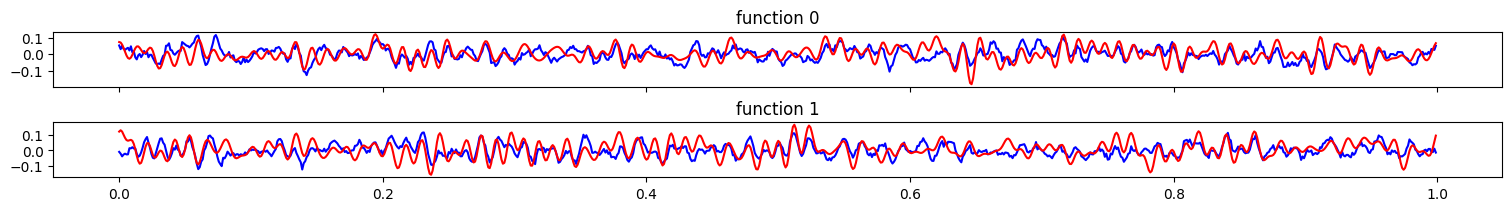

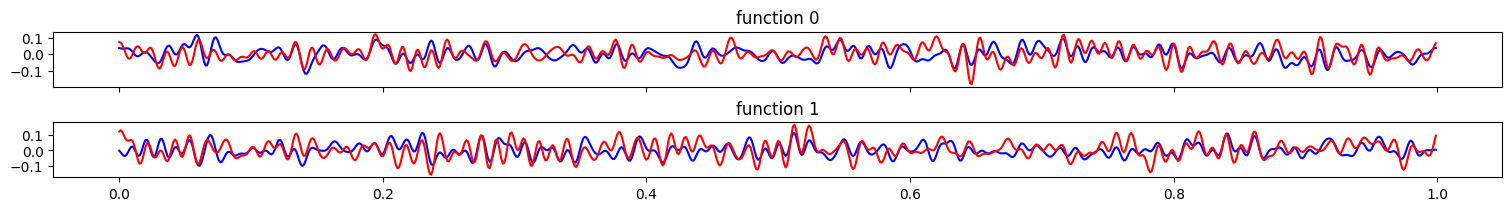

In [9]:
# do this because forward in SpectralSVR isn't scaling invariant
u_test_basis = FourierBasis(u_coeff_test)
u_test_eval = u_test_basis.evaluate(points_tt)
def plot_funcs(u_pred:torch.Tensor, u:torch.Tensor, n=6):
    # line_styles = ["solid", "dotted", "dashed", "dashdot"]
    fig, axs = plt.subplots(n, 1, figsize=[15, n], constrained_layout=True, sharex=True)
    for i in range(n):
        # axs[i%2, i//2].scatter(points_sampled[:,1], u_sampled[i, :])
        # axs[i%2, i//2].plot(t, u_basis_pred[i].real, color="black")
        # axs[i].plot(t, u_test[i].real, color="blue")
        axs[i].plot(t, u[i].real, color="blue")
        axs[i].plot(t, u_pred[i].real, color="red")
        axs[i].set_title(f"function {i}")

    plt.show()

plot_funcs(u_pred, u_test, 2)
plot_funcs(u_pred, u_clean[dataset_test.indices[0:10]], 2)

In [10]:
f_test, f_coeff_test, u_test, u_coeff_test = dataset_test[0:10]
u_test_basis = FourierBasis(u_coeff_test, periods=periods)
u_inv = u_test_basis.evaluate(points_tt).real
inverse_pred = model.inverse(u_inv, points_tt, epochs=5000, lr=0.01, amsgrad=True).detach()


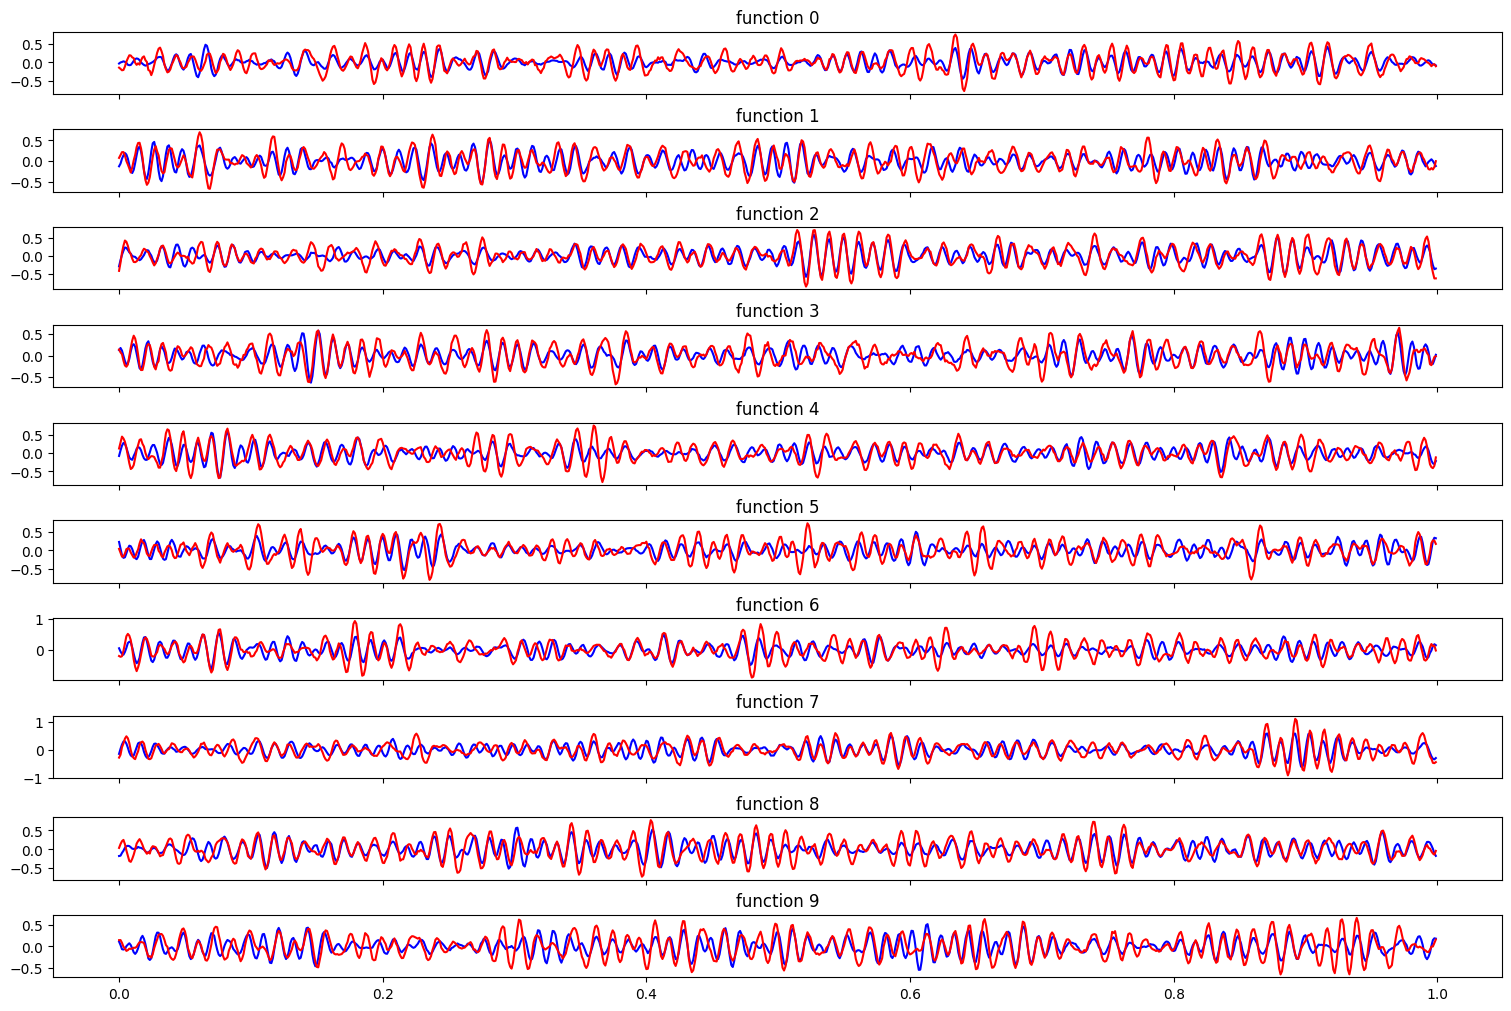

In [11]:
# f_truth = f_test
f_truth = FourierBasis(periods=periods).evaluate(points_tt, f_coeff_test, periods,modes=modes)
plot_funcs(inverse_pred, f_test, n=10)

In [12]:
# tmp_test = torch.randn((2000, 2000))
# tmp_unscaled = LSSVR(kernel="tri", sigma=1.0)
# tmp_prod = 1 - tmp_unscaled._batched_K(tmp_test, tmp_test)
# display(tmp_prod)
# tmp_sigma = tmp_prod.max()
# tmp_model = LSSVR(kernel="rbf", sigma =tmp_test.var(0).sum()**.5)
# tmp_gram = tmp_model._batched_K(tmp_test,tmp_test)
# display(tmp_gram)
# def is_psd(mat):
#     return bool((mat == mat.T).all() and (torch.linalg.eigvals(mat).real>=0).all())
# #Test:
# display(is_psd(tmp_gram), is_psd(tmp_prod))
# model.svr.K
# display((tmp_gram == tmp_gram.T).all())
# tmp_eig = torch.linalg.eigvals(tmp_gram).real
# display(tmp_eig[(tmp_eig>=0 )== False], tmp_eig.shape)